**Summary:** This file is intended for an end-to-end demonstration of BTK capabilities for the July Meeting 2020 Guided Sprint

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
import btk.plot_utils, btk.utils
import astropy.table
import inspect
import descwl

In [8]:
import sep
import sklearn

# Load Params 

In this first part we establish a set of parameters that we'll be using throughout the tutorial. You can think of them as user-defined global variables that are used throughout the simulations in BTK. 
These parameters will be fixed throughout this tutorial as well. 

Note that the `verbose` flag is turned off, in case you would like additional messages that show the functionality you can turn it on. 

In [9]:
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')
param = btk.config.Simulation_params(catalog_name, max_number=6, batch_size=2, verbose=False)
np.random.seed(param.seed)

In [10]:
# If you forgot what parameters you used, you can quickly display them like 
param.display()


Configurations:
add_noise                      True
bands                          ('u', 'g', 'r', 'i', 'z', 'y')
batch_size                     2
catalog_name                   /Users/Ismael/code/deblend/BlendingToolKit/data/sample_input_catalog.fits
max_number                     6
meas_band                      i
min_snr                        0.05
pixel_scale                    0.2
seed                           0
stamp_size                     24
survey_name                    LSST
verbose                        False




# Load Catalog

Let's load the small catalog that we will be using. 

The file containing this catalog can be found in the `catalog_name` attribute of `param` as shown above. 

In [11]:
catalog = btk.get_input_catalog.load_catalog(param)

# as you can see this is just a astropy table. 
print(type(catalog))
print(len(catalog))

<class 'astropy.table.table.Table'>
100


As you can see this catalog only contains 100 entries. 

## selection function 

One can optionally apply selection function at this step, there is the basic selection function already implemented inside BTK in `btk.utils` that we will use as an example: 

In [11]:
# this function selects everything with i band mag < 27 and second moment size < 4 arcsecs 
print(inspect.getsource(btk.utils.basic_selection_function))

def basic_selection_function(catalog):
    """Apply selection cuts to the input catalog.

    Only galaxies that satisfy the below criteria are returned:
    1) i band magnitude less than 27
    2) Second moment size is less than 4 arcsec.
    Second moments size (r_sec) computed as described in A1 of Chang et.al 2012

    Args:
        catalog: CatSim-like catalog from which to sample galaxies.

    Returns:
        CatSim-like catalog after applying selection cuts.
    """
    f = catalog['fluxnorm_bulge'] / (catalog['fluxnorm_disk'] +
                                     catalog['fluxnorm_bulge'])
    r_sec = np.hypot(catalog['a_d'] * (1 - f) ** 0.5 * 4.66,
                     catalog['a_b'] * f ** 0.5 * 1.46)
    q, = np.where((r_sec <= 4) & (catalog['i_ab'] <= 27))
    return catalog[q]



As you can see in the function above, a `selection_function` simply takes in the catalog and 
returns a new (filtered) one. 

In the example below, we can see how the filtering of the `selection_function` reduced the number of objects.

In [12]:
# After defining the function, you can use it like: 
catalog = btk.get_input_catalog.load_catalog(param, selection_function=btk.utils.basic_selection_function)
len(catalog)

69

## Exercise: Custom selection function

Create your own selection function that make a cut in the r band magnitude instead of the `i` band magnitude. How different is your resulting catalog from the original one? 

# Create blend generator 

A `generator` is python jargon - it's a convenient data structure that only returns one object at a time. Never loading all of the objects into memory at once. 

`BTK` uses generators to generate batches of images and corresponding parameters on the fly. We will now work on an example. 

A `blend_generator` uses a `sampling_function` which defines how BTK generates and returns blends (groups of galaxies in a postage stamp that are considered 'blended' and that are drawn together). As you might expect, a `sampling_function` is required by BTK, passing in `None` like below actually uses the default sampling function. 

In [13]:
blend_generator = btk.create_blend_generator.generate(param, catalog, sampling_function=None)

Here is the `sampling_function` used:

In [14]:
print(inspect.getsource(btk.create_blend_generator.default_sampling))

def default_sampling(Args, catalog):
    """Applies default sampling to the input CatSim-like catalog and returns
    catalog with entries corresponding to a blend centered close to postage
    stamp center.

    Function selects entries from input catalog that are brighter than 25.3 mag
    in the i band. Number of objects per blend is set at a random integer
    between 1 and Args.max_number. The blend catalog is then randomly sampled
    entries from the catalog after selection cuts. The centers are randomly
    distributed within 1/10th of the stamp size. Here even though the galaxies
    are sampled from the CatSim catalog, their spatial location are not
    representative of real blends.

    Args:
        Args: Class containing input parameters.
        catalog: CatSim-like catalog from which to sample galaxies.

    Returns:
        Catalog with entries corresponding to one blend.
    """
    number_of_objects = np.random.randint(1, Args.max_number + 1)
    q, = np.where(catalo

The `sampling_function` should always be returning a `blend_catalog`, which is a (random) small subset from the catalog that defines a blend. In the example above, we are sampling a subset of size `number_of_objects` from the `catalog` after making a more stringent cut on i band magnitude and randomly shifting each galaxy from the center. 

## Exercise: Sampling function using RA/DEC 

Create a `sampling_function` that only returns objects that are close to each other (you can decide the threshold) as measured by `RA/DEC`. 
In the later parts of this tutorial we'll draw actual images resulting from a given sampling function and you should check that your galaxies look reasonably close by eye. 

## Hack Idea 

If you would like to contribute to BTK and extend the sampling function that you created above, please take a look at this issue: https://github.com/LSSTDESC/BlendingToolKit/issues/16

# Observing generator 

Now we turn to specifying the observational conditions for the blends created. Currently, the observing conditions are specified via the [WeakLensingDeblending](https://weaklensingdeblending.readthedocs.io/en/latest/) package (WLD), this package contains an object called `descwl.survey.Survey` that internally specifies observing conditions. Changeable parameters from the survey object include: 

- mirror_diameter
- effective_area 
- pixel_scale 
- airmass
- exposure_time
- sky_brightness 
- zenith_psf_fwhm
- zero_points
- extinction 

The PSF used for both the optics in the atmosphere are either a Moffat or Kolmogorov model. For more details see the [source code](https://github.com/ismael2395/WeakLensingDeblending/blob/master/descwl/survey.py) of `descwl.survey`.

The default observing conditions function in BTK are just constant across batches and will always return the defaults in the WLD package. 

In [19]:
print(inspect.getsource(btk.create_observing_generator.default_obs_conditions))

def default_obs_conditions(Args, band):
    """Returns the default observing conditions from the WLD package
    for a given survey_name and band.

    Args:
        Args: Class containing parameters to generate blends
        band: filter name to get observing conditions for.
    Returns:
        `descwl.survey.Survey`: WLD survey class with observing conditions.
    """
    survey = descwl.survey.Survey.get_defaults(
        survey_name=Args.survey_name,
        filter_band=band)
    return survey



In [30]:
observing_generator = btk.create_observing_generator.generate(param, obs_function=None)

## Example of custom observing conditions 

Here is an example of a customized observing conditions function, different batches will have different observing conditions as they are produced. 

In [16]:
def custom_obs_condition(Args, band):
    """Returns observing conditions from the WLD package
    for a given survey_name and band with a small offset from
    the default parametrs.
    Args
        Args: Class containing parameters to generate blends
        band: filter name to get observing conditions for.
    Returns
        survey: WLD survey class with observing conditions.
    """
    survey = descwl.survey.Survey.get_defaults(
        survey_name=Args.survey_name,
        filter_band=band)
    survey['exposure_time'] = random.uniform(10, survey['exposure_time'])
    survey['zenith_psf_fwhm'] += random.uniform(-0.3,0.3)
    return survey

In [17]:
# Here is how to use it: 
observing_generator = btk.create_observing_generator.generate(param, obs_function=custom_obs_condition)

# Draw blends

## Setup

Here I'm just gathering all the results from the previous sections in case you want to experiment quickly by changing one of the generators. 

Remember that all the `None` statements below can be replaced with your favorite customized function, but I just let them be `None` here for simplicity (uses `BTK` default as explained in the sections above).  

In [18]:
# setup params and catalog 
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')
param = btk.config.Simulation_params(catalog_name, max_number=6, batch_size=2, verbose=False)
catalog = btk.get_input_catalog.load_catalog(param, selection_function=None)
blend_generator = btk.create_blend_generator.generate(param, catalog, sampling_function=None)
observing_generator = btk.create_observing_generator.generate(param, obs_function=None)

## Draw blend generator

Now we get to play with some images :) We will put together all the generators we have built so far and create some images simulated with `galsim` by interfacing with the WLD package and BTK. 

We first need one more generator created from the other two generators: `draw_blend_generator`

In [19]:
#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

In [20]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

In [21]:
output.keys()

dict_keys(['blend_images', 'isolated_images', 'blend_list', 'obs_condition'])

Note the following: 

- Each time the function `next` is used on `draw_blend_generator` a fresh batch of data is simulated (based on your pre-specified `blend_generator` and `observing_generator`.

- The output of the `draw_blend_generator` is a `dict` containing the following: 

    - `blend_images`: A `np.array` of shape `batch_size x stamp_size x stamp_size x n_bands`. This contains the actual postage stamps with the blends.
                        
    - `isolated_images`: A `np.array` of shape `batch_size x max_objects x stamp_size x stamp_size x n_bands`. This contains the images that were added together the create the `blend_images`.   
    
    - `blend_list`: A list of `astroy.Table`s containing the source catalog of each blend in the batch. 
    
    - `obs_condition`: A list of `batch_size` of list of `n_bands` observing conditions  `n_bands` that is used for every element in the batch. 

## Draw some blends!

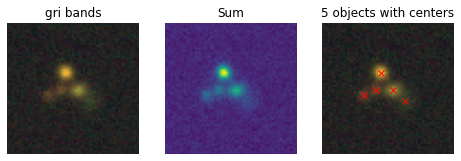

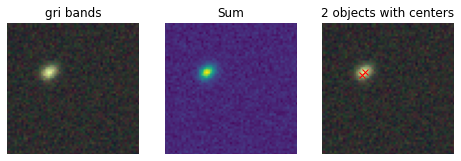

In [26]:
# Plot blended images
btk.plot_utils.plot_blends(blend_images, blend_list, limits=(30,90))

#this also shows the true centers of the drawn galaxies with a red 'x'

In case you would also like to see each individual source in the blend you can take a look at the `isolated_images` 

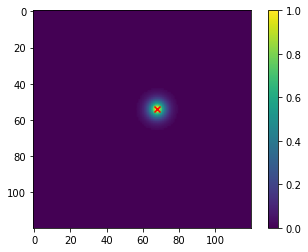

In [58]:
# plot the first source in the first blend in the 'i' band. 
# mark its appropriate position manually from the blend list. 
plt.imshow(isolated_images[0][0][...,3])
plt.scatter(blend_list[0][0]['dx'], blend_list[0][0]['dy'], marker='x', color='r')
plt.colorbar()
# the colobar shows how all images are normalized from 0 to 1. 

## Exercise: Other observing conditions 

Recreate some of the plots above with different `obs_conditions`, you can use the `custom_obs_condition` as a start. Are the observing conditions the same across different batches? Can you understand why the images produced make sense given the observing conditions that you changed? 

## Exercise: User-defined sampling function output

Generate some more blend plots using a different `sampling_function`, you can use the one suggested in the exercise above or create your own. 

## Exercise: Realistic blends 

It is possible to create more realistic blends using BTK and the WeakLensingDeblending (WLD) package. The `WLD` package is able to assign galaxies to groups by drawing in a particular catalog under some pre-specified observing conditions, and putting together all the galaxies that have at least 1 overlapping pixel (above some threshold). 

There is an example of a small catalog processed with WLD in the BTK repo that you can use to experiment with this feature: `data/sample_group_catalog.fits`, if you load this table you should notice the column `grp_id` which is ID identifying the groups selected by `WLD`. 

In [42]:
catalog_file = "../data/sample_group_catalog.fits"

In `BTK` there is already a sampling function that you can use to sample groups from this catalog: `btk.utils.group_sampling_function`. Feel free to take a look at this function and use it to generate some blends from the catalog just mentioned. Do these blends look any different from the ones you produced in the previous exercises or with the `default_sampling_function`. 

## More resources

For more resouces on custom observing conditions and sampling functions, take a look at this notebook: `notebooks/custom_sampling_function.ipynb` or in this github link: https://github.com/LSSTDESC/BlendingToolKit/blob/master/notebooks/custom_sampling_function.ipynb

# Create Measure generator 

In this next part, we will see how we can combine the functionality of creating blends in BTK  with our favorite detection/deblending/measurement algorithms. 

For simplicity let's start by defining everything we did so far in one function. 

In [44]:
def get_draw_blend_generator():
    # Load parameters
    #Input catalog name
    catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sample_input_catalog.fits')
    param = btk.config.Simulation_params(catalog_name,batch_size=2, max_number=3 )
    np.random.seed(param.seed)

    #Load input catalog
    catalog = btk.get_input_catalog.load_catalog(param)

    #Generate catlogs of blended objects 
    blend_generator = btk.create_blend_generator.generate(param, catalog)

    #Generates observing conditions for the selected survey_name and all input bands
    observing_generator = btk.create_observing_generator.generate(param)

    #Generate images of blends in all the observing bands
    draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator)
    return draw_blend_generator

In [45]:
draw_blend_generator = get_draw_blend_generator()

Measurement/Deblending in BTK is structured very similarly to the previous approaches: using a generator. The reason for this is that the measurement might produce additional images or data that is later summarized, so it makes sense to not store it all at once but rather aggregate at the end if desired. 

The functionality that a user needs to add to BTK in order to specify their own algorithm is summarized in a class `btk.measure.Measurement_params`. You need to implement one of two functions:

- `make_measurement`: Given a dictionary `data` (`output` in the above section) return an astropy table with the measurements you made (fluxes, shapes, size, etc.) for each object in the blend. 

- `get_deblended_images`: Return output of deblending algorithm as dict. 

We will now walk through an example demonstration. 

Here is an example class to perform peak detection with sklearn that is copied from `btk.utils` :

## Detection 

In [55]:
class Basic_measure_params(Measurement_params):
    """Class to perform detection by identifying peaks with skimage"""

    def get_centers(self, image):
        # set detection threshold to 5 times std of image
        threshold = 5 * np.std(image)
        coordinates = skimage.feature.peak_local_max(image, min_distance=2,
                                                     threshold_abs=threshold)
        return np.stack((coordinates[:, 1], coordinates[:, 0]), axis=1)

    def get_deblended_images(self, data, index):
        """Returns scarlet modeled blend and centers for the given blend"""
        image = np.mean(data['blend_images'][index], axis=2)  # don't use multi-band information. 
        peaks = self.get_centers(image)
        return {'deblend_image': None, 'peaks': peaks}

In [56]:
#this is how we specify the measurement params
meas_params = btk.utils.Basic_measure_params()

In [57]:
# get generator that yields measured values.
meas_generator = btk.measure.generate(
        meas_params, get_draw_blend_generator(), param)

In [63]:
summary

[[2, 1, 1, 0, 0, 1, 1, 0, 0]]

In [65]:
true_table

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,dx,dy,size,not_drawn_u,not_drawn_g,not_drawn_r,not_drawn_i,not_drawn_z,not_drawn_y,true_id,blend_index,batch_index,num_detections1,num_detections2,closest_det_id1,closest_det_id2,dm_match,dz_match,ddist_match,dnorm_dist_match,min_dist
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64
2202484794,-0.5549678049950408,-2.127777708876273,0.737505495548,0.0,6.11022188471e-18,0.0,0.0,0.403777301311,0.0,0.195289194584,0.0,232.21925354,26.6245307922,26.2098960876,25.5539073944,24.7192592621,24.4865779877,24.3074092865,56.72516097502479,48.86111145561864,7.148459565509727,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.982133865399998,0.150180518627,5.58607077138991,0.665691816072416,5.58607077138991
2201085841,-0.971833888586533,-1.0912497860154566,0.587324976921,0.0,1.12263802955e-17,0.0,0.0,0.427114099264,0.0,0.267916589975,0.0,195.013763428,25.0308609009,24.8065452576,24.1531715393,23.7371253967,23.60688591,23.5045719147,54.64083055706733,54.04375106992272,8.39137666487737,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,0,0,0.0,0.0,0.0,0.0,5.58607077138991


Out of 1 objects, 1 detected, 0 undetected, & 0  spurious detections


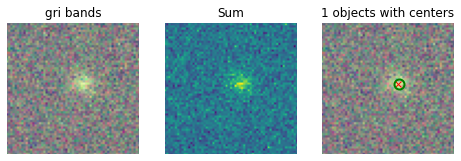

Out of 2 objects, 1 detected, 1 undetected, & 0  spurious detections


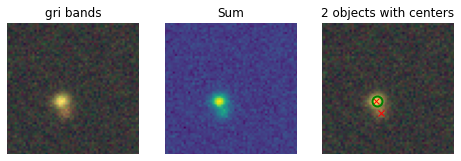

In [59]:
output, deb, _ = next(meas_generator)  # obtain simulation measurement output for this next batch. 
blend_list = output['blend_list']
for i in range(len(blend_list)):
    blend_images = output['blend_images'][i:i+1]
    detected_centers = deb[i]['peaks']
    true_centers = np.stack([blend_list[i]['dx'], blend_list[i]['dy']]).T
    true_table = blend_list[i]
    det_table = astropy.table.Table(detected_centers, names=('dx', 'dy'))
    _, _, summary = btk.compute_metrics.evaluate_detection([true_table], [det_table], 0)
    det, undet, spur = summary[0][1:4]
    print("Out of %i objects, %i detected, %i undetected, & %i  spurious detections"%(len(true_centers), det, undet, spur))
    btk.plot_utils.plot_blends(blend_images, blend_list[i: i+1], [detected_centers],limits=(30,90))

We can see how to basic `skimage` algorithm misses detection when the amount of blending is considerable. 

# Metrics

# Config File 